In [67]:
TRACK = "tracks/July_2020.npy"

In [59]:
import math
from typing import Any, Dict, List, Tuple

ParamType = Dict[str, Any]
VecType = Tuple[float, float]


def p_dist(p1: VecType, p2: VecType) -> float:
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    return math.sqrt(dx * dx + dy * dy)


def vec_bisector_angle(vec_a: VecType, vec_b: VecType) -> VecType:
    len_va = math.sqrt(vec_a[0] * vec_a[0] + vec_a[1] * vec_a[1])
    len_vb = math.sqrt(vec_b[0] * vec_b[0] + vec_b[1] * vec_b[1])

    vec_bis = (
        len_vb * vec_a[0] + len_va * vec_b[0],
        len_vb * vec_a[1] + len_va * vec_b[1],
    )
    len_bis = math.sqrt(vec_bis[0] * vec_bis[0] + vec_bis[1] * vec_bis[1])
    return (vec_bis[0] / len_bis, vec_bis[1] / len_bis)


def make_waypoints_distinct(params: ParamType) -> List[VecType]:
    wp = params["waypoints"]
    wp_cut = [wp[0]]
    for p in wp[1:-1]:
        if p != wp_cut[-1]:
            wp_cut.append(p)
    if wp_cut[0] != wp[-1]:
        wp_cut.append(wp[-1])
    return wp_cut


def aug_waypoints_horizontally(
    wp: List[VecType], params: ParamType
) -> List[List[VecType]]:
    wp_auged = []
    for i in range(len(wp) - 1):
        pre = wp[(i + len(wp) - 1) % len(wp)]
        now = wp[i]
        nex = wp[(i + 1) % len(wp)]
        vec_a = (pre[0] - now[0], pre[1] - now[1])
        vec_b = (nex[0] - now[0], nex[1] - now[1])

        vec_t = vec_bisector_angle(vec_a, vec_b)
        _fracs = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
        fracs = [params["track_width"] * 0.5 * f for f in _fracs]
        auged = [(now[0] + vec_t[0] * f, now[1] + vec_t[1] * f) for f in fracs]
        wp_auged.append(auged)
    return wp_auged


def calc_shortest_path(
    src: Tuple[int, int], steps: int, wp_auged: List[List[VecType]]
) -> List[int]:
    INF = 99999999.0
    width = len(wp_auged[0])
    dp_dist = [[INF] * width for _ in range(steps)]
    prev = [[-1] * width for _ in range(steps)]

    nex = (src[0] + 1) % len(wp_auged)
    for i in range(width):
        dp_dist[0][i] = p_dist(wp_auged[src[0]][src[1]], wp_auged[nex][i])
        prev[0][i] = src[1]

    for i in range(1, steps):
        pre = (src[0] + i) % len(wp_auged)
        nex = (pre + 1) % len(wp_auged)
        for j in range(width):
            for k in range(width):
                dist = p_dist(wp_auged[pre][j], wp_auged[nex][k])
                if dp_dist[i - 1][j] + dist < dp_dist[i][k]:
                    dp_dist[i][k] = dp_dist[i - 1][j] + dist
                    prev[i][k] = j

    destination = dp_dist[steps - 1].index(min(dp_dist[steps - 1]))
    shortest_path = [destination]
    for i in range(1, steps):
        shortest_path.append(prev[steps - i][shortest_path[-1]])

    return shortest_path[::-1]


def calc_all_shortest_paths(
    steps: int, wp_auged: List[List[VecType]]
) -> List[List[List[int]]]:
    shortest_paths = [[] for _ in range(len(wp_auged))]
    width = len(wp_auged[0])
    for i in range(len(wp_auged)):
        for j in range(width):
            path = calc_shortest_path((i, j), steps, wp_auged)
            shortest_paths[i].append(path)
    return shortest_paths

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
arr = np.load(TRACK)

In [5]:
arr

array([[-0.73072696, -0.85972022, -0.7310794 , -0.40252039, -0.73037452,
        -1.31692004],
       [-1.152821  , -0.86004008, -1.15281403, -0.40283921, -1.15282798,
        -1.31724095],
       [-1.57060248, -0.86003752, -1.57058895, -0.40283599, -1.57061601,
        -1.31723905],
       ...,
       [-0.05159832, -0.86063978, -0.05047119, -0.40344161, -0.05272545,
        -1.31783795],
       [-0.38474761, -0.85981847, -0.38461721, -0.40261891, -0.38487801,
        -1.31701803],
       [-0.73072696, -0.85972022, -0.7310794 , -0.40252039, -0.73037452,
        -1.31692004]])

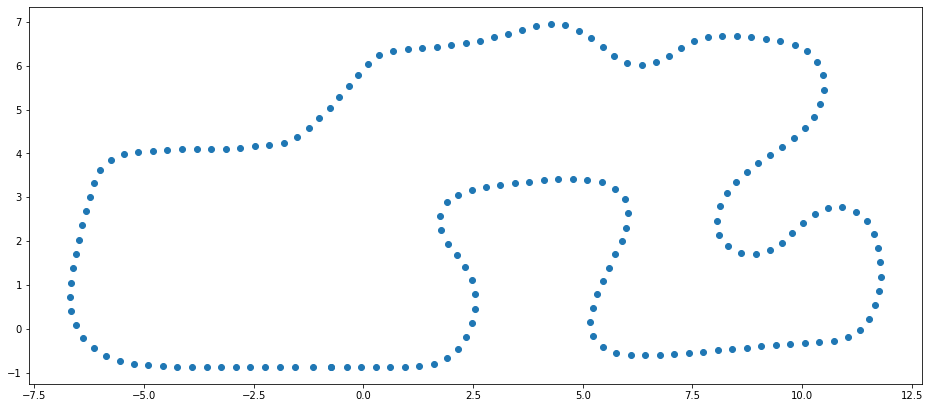

In [25]:
# センターラインのプロット
x = [p[0] for p in arr]
y = [p[1] for p in arr]

fig = plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal')
plt.scatter(x, y)

In [27]:
params = {}

In [28]:
params["waypoints"] = [(float(p[0]), float(p[1])) for p in arr]

In [30]:
x0, y0 = arr[0][2], arr[0][3]
x1, y1 = arr[0][4], arr[0][5]
dx = x0 - x1
dy = y0 - y1

params["track_width"] = math.sqrt(dx * dx + dy * dy)

In [31]:
wp_cut = make_waypoints_distinct(params)

In [32]:
wp_auged = aug_waypoints_horizontally(wp_cut, params)

In [33]:
wp_auged

[[(-0.7308136081320171, -0.49396025532112037),
  (-0.7307919454293046, -0.5854002452911848),
  (-0.7307702827265921, -0.6768402352612491),
  (-0.7307486200238795, -0.7682802252313135),
  (-0.730726957321167, -0.8597202152013779),
  (-0.7307052946184545, -0.9511602051714423),
  (-0.7306836319157419, -1.0426001951415067),
  (-0.7306619692130294, -1.134040185111571),
  (-0.7306403065103169, -1.2254801750816353)],
 [(-1.1526835375327749, -1.2258000278391772),
  (-1.1527179042472602, -1.134360041761274),
  (-1.1527522709617457, -1.042920055683371),
  (-1.152786637676231, -0.951480069605468),
  (-1.1528210043907166, -0.860040083527565),
  (-1.152855371105202, -0.768600097449662),
  (-1.1528897378196874, -0.6771601113717589),
  (-1.152924104534173, -0.585720125293856),
  (-1.1529584712486582, -0.4942801392159529)],
 [(-1.5706080840061283, -1.225797490629172),
  (-1.5706066821538043, -1.134357498103839),
  (-1.5706052803014803, -1.0429175055785058),
  (-1.5706038784491563, -0.9514775130531727)

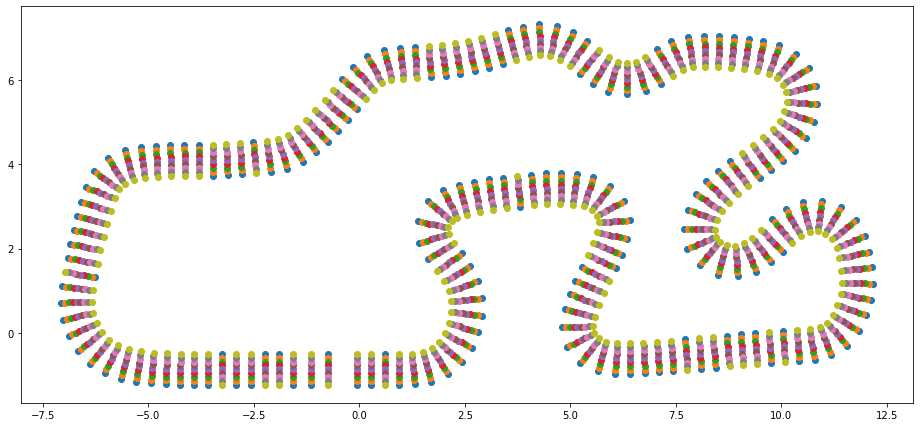

In [66]:
fig = plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal')

for i in range(len(wp_auged[0])):
    x = [p[i][0] for p in wp_auged]
    y = [p[i][1] for p in wp_auged]
    plt.scatter(x, y)

In [60]:
paths = calc_all_shortest_paths(len(wp_auged), wp_auged)

In [62]:
len(paths[0][0])

179

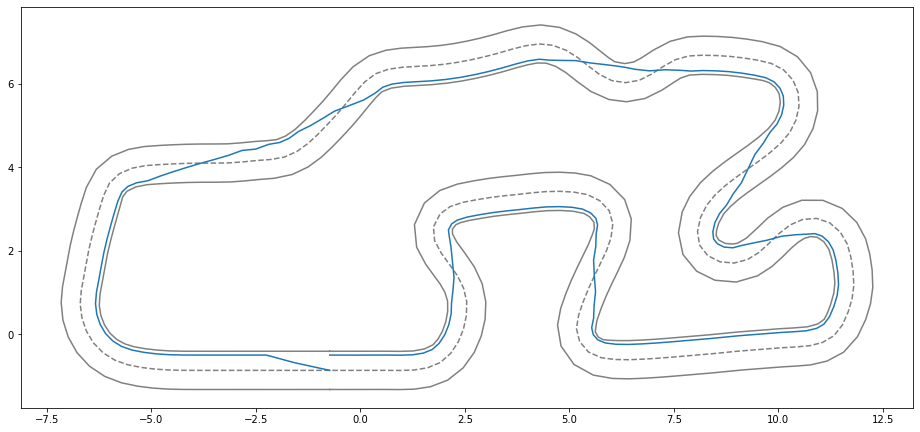

In [63]:
fig = plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal')

# センターラインのプロット
x = [p[0] for p in arr]
y = [p[1] for p in arr]
plt.plot(x, y, linestyle="dashed", color="gray")

# 内側、外側のプロット
x = [p[2] for p in arr]
y = [p[3] for p in arr]
# plt.axes().set_aspect('equal')
plt.plot(x, y, color="gray")

x = [p[4] for p in arr]
y = [p[5] for p in arr]
# plt.axes().set_aspect('equal')
plt.plot(x, y, color="gray")

# 最短経路のプロット
start = (0, 4)
pts = [wp_auged[start[0]][start[1]]]
for i in range(len(paths[start[0]][start[1]])):
    pts.append(wp_auged[(start[0] + i + 1) % len(wp_auged)][paths[start[0]][start[1]][i]])
x = [p[0] for p in pts]
y = [p[1] for p in pts]
plt.plot(x, y)